In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
pd.options.display.max_rows = 2000
plt.style.use('ggplot')

C:\Users\olegh\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Import datasets and resample for use
df1 = pd.read_csv('t1.csv', index_col = 0, parse_dates = True)
df1 = df1.resample('15T').mean()
df1.interpolate(method = 'time', inplace=True)

df2 = pd.read_csv('t2.csv', index_col = 0, parse_dates = True)
df2 = df2['2015-09-10':]
df2 = df2.resample('15T').mean()
df2.interpolate(method = 'time', inplace=True)

df3 = pd.read_csv('t3.csv', index_col = 0, parse_dates = True)
df3 = df3['2015-09-10':]
df3 = df3.resample('15T').mean()
df3.interpolate(method = 'time', inplace=True)

df4 = pd.read_csv('twitter.csv', index_col = 0, parse_dates = True)

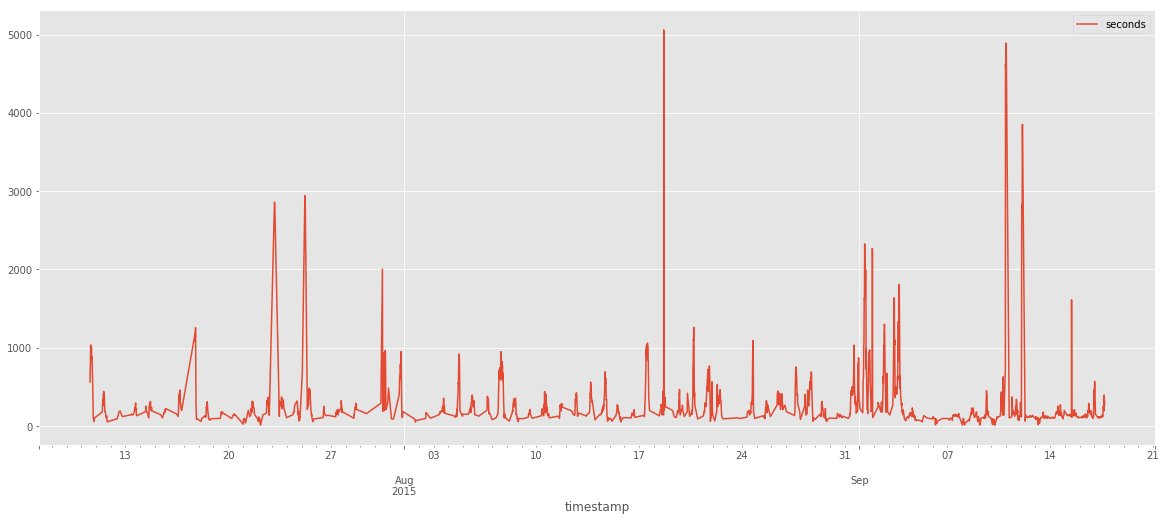

In [3]:
df1.plot(figsize = (20, 8))

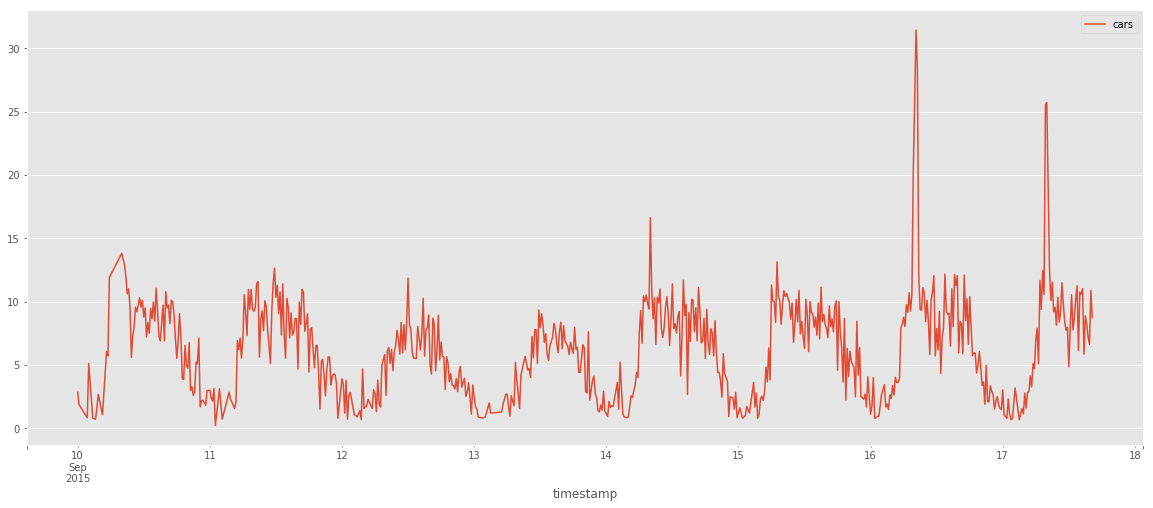

In [4]:
df2.plot(figsize = (20, 8))

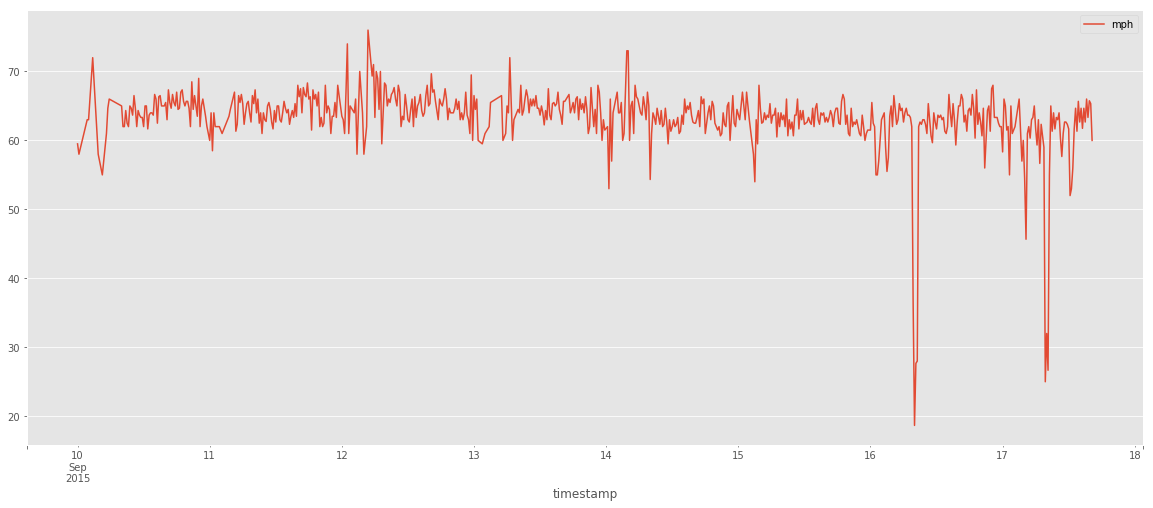

In [5]:
df3.plot(figsize = (20, 8))

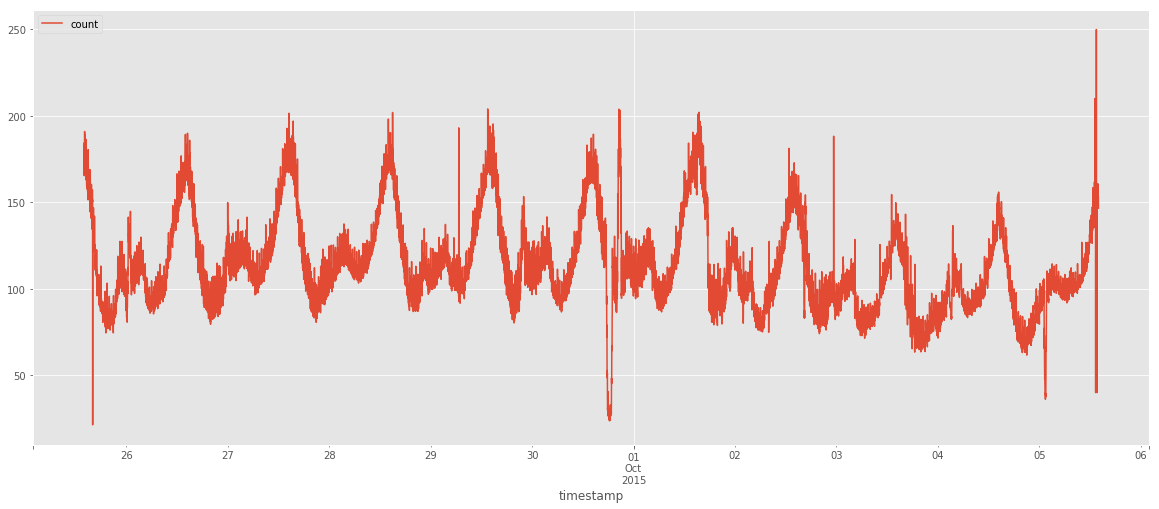

In [6]:
df4.plot(figsize = (20, 8))

### Median Absolute Deviation

In [7]:
#Copy datasets for use in Median Absolute Deviation and set standard deviations
s = 3
m1 = df1.copy()
m2 = df2.copy()
m3 = df3.copy()
m4 = df4.copy()

In [8]:
#Set Median Absolute Deviation parameters for each dataset 
m1['rm'] = m1.rolling(window = 96).median()
m1['rmt'] = m1['rm'] + (abs(m1['seconds'] - m1['seconds'].median()).rolling(window = 96).median() * 1.4826) * s
m1['rmb'] = m1['rm'] - (abs(m1['seconds'] - m1['seconds'].median()).rolling(window = 96).median() * 1.4826) * s

m2['rm'] = m2.rolling(window = 96).median()
m2['rmt'] = m2['rm'] + (abs(m2['cars'] - m2['cars'].median()).rolling(window = 96).median() * 1.4826) * s
m2['rmb'] = m2['rm'] - (abs(m2['cars'] - m2['cars'].median()).rolling(window = 96).median() * 1.4826) * s

m3['rm'] = m3.rolling(window = 96).median()
m3['rmt'] = m3['rm'] + (abs(m3['mph'] - m3['mph'].median()).rolling(window = 96).median() * 1.4826) * s
m3['rmb'] = m3['rm'] - (abs(m3['mph'] - m3['mph'].median()).rolling(window = 96).median() * 1.4826) * s

m4['rm'] = m4.rolling(window = 1440).median()
m4['rmt'] = m4['rm'] + (abs(m4['count'] - m4['count'].median()).rolling(window = 1440).median() * 1.4826) * s
m4['rmb'] = m4['rm'] - (abs(m4['count'] - m4['count'].median()).rolling(window = 1440).median() * 1.4826) * s

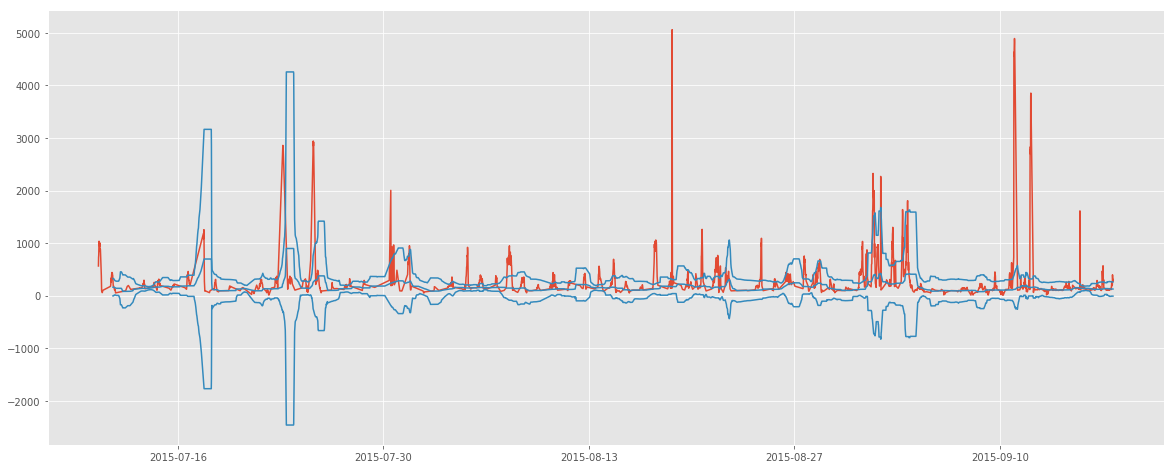

In [9]:
plt.figure(figsize = (20, 8))
plt.plot(m1.seconds, color='C0')
plt.plot(m1.rm, color='C1')
plt.plot(m1.rmt, color='C1')
plt.plot(m1.rmb, color='C1')

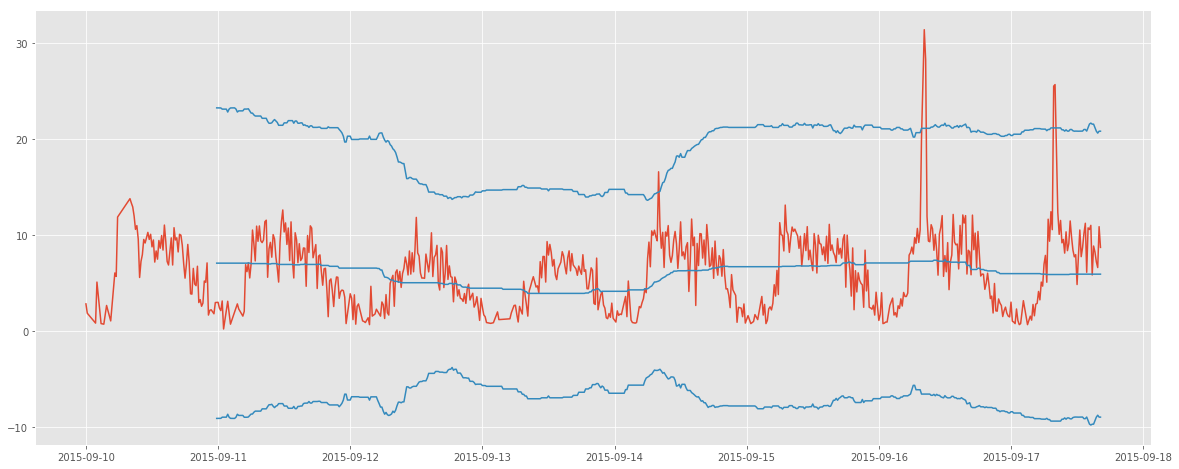

In [10]:
plt.figure(figsize = (20, 8))
plt.plot(m2.cars, color='C0')
plt.plot(m2.rm, color='C1')
plt.plot(m2.rmt, color='C1')
plt.plot(m2.rmb, color='C1')

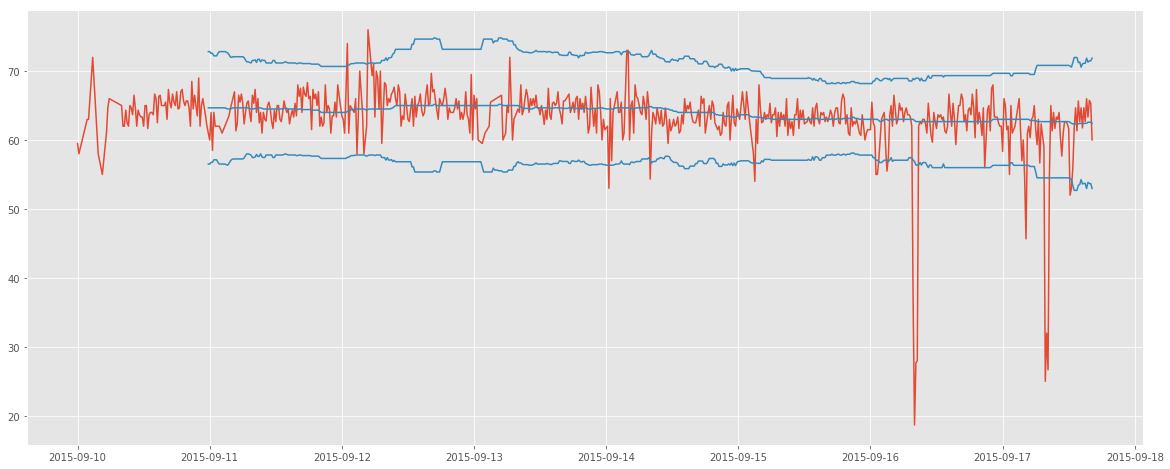

In [11]:
plt.figure(figsize = (20, 8))
plt.plot(m3.mph, color='C0')
plt.plot(m3.rm, color='C1')
plt.plot(m3.rmt, color='C1')
plt.plot(m3.rmb, color='C1')

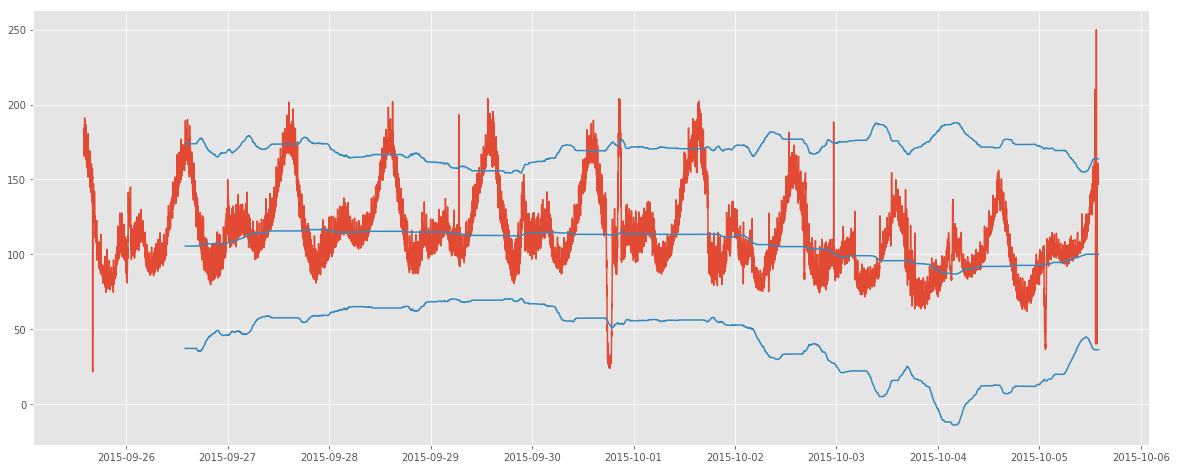

In [12]:
plt.figure(figsize = (20, 8))
plt.plot(m4['count'], color='C0')
plt.plot(m4.rm, color='C1')
plt.plot(m4.rmt, color='C1')
plt.plot(m4.rmb, color='C1')

In [13]:
#Identify anomalies if they exceed 3 standard deviations
m1['anomaly'] = [ 1 if (i> m1['rmt'][p]) else 0 for p,i in enumerate(m1['seconds'])]
m2['anomaly'] = [ 1 if (i> m2['rmt'][p]) or (i< m2['rmb'][p]) else 0 for p,i in enumerate(m2['cars'])]
m3['anomaly'] = [ 1 if (i> m3['rmt'][p]) or (i< m3['rmb'][p]) else 0 for p,i in enumerate(m3['mph'])]
m4['anomaly'] = [ 1 if (i> m4['rmt'][p]) or (i< m4['rmb'][p]) else 0 for p,i in enumerate(m4['count'])]

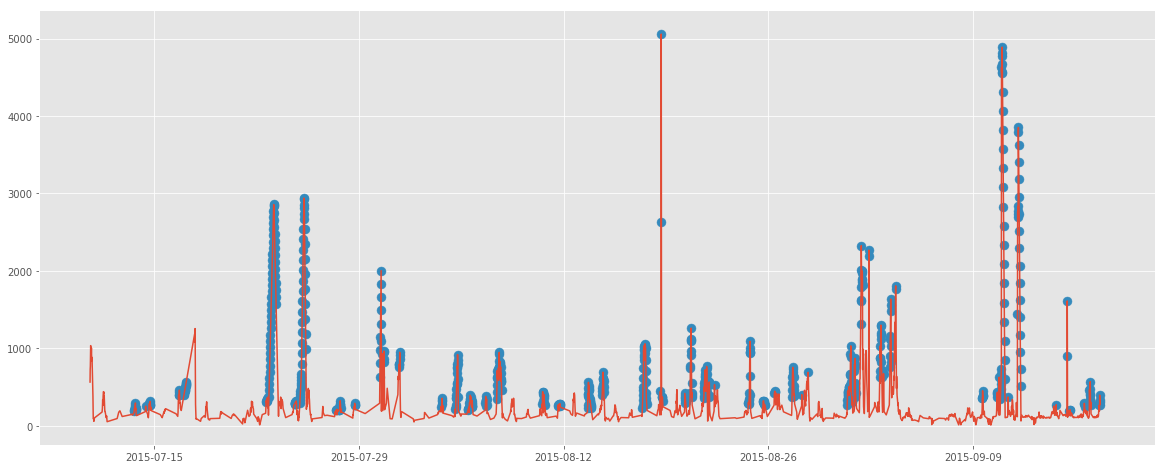

In [14]:
plt.figure(figsize = (20, 8))
plt.plot(m1['seconds'], color='C0')
plt.scatter(m1.index[m1['anomaly']==1], m1['seconds'][m1['anomaly']==1], color='C1', s=80)
plt.show()

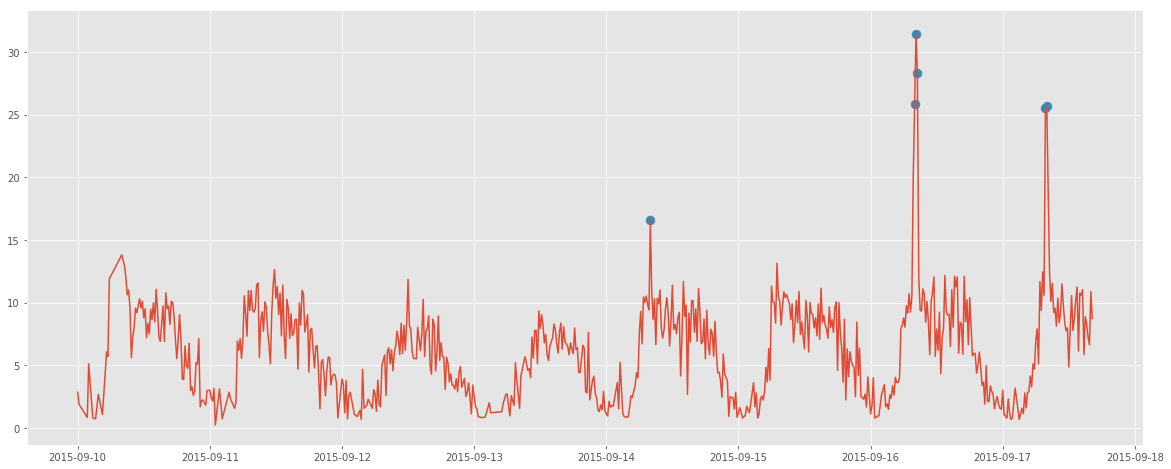

In [15]:
plt.figure(figsize = (20, 8))
plt.plot(m2['cars'], color='C0')
plt.scatter(m2.index[m2['anomaly']==1], m2['cars'][m2['anomaly']==1], color='C1', s=80)
plt.show()

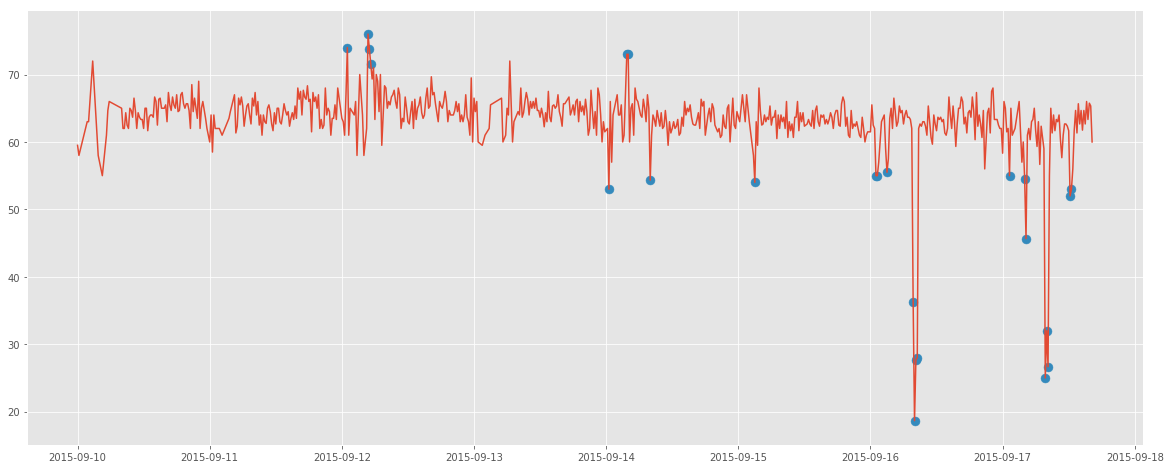

In [16]:
plt.figure(figsize = (20, 8))
plt.plot(m3['mph'], color='C0')
plt.scatter(m3.index[m3['anomaly']==1], m3['mph'][m3['anomaly']==1], color='C1', s=80)
plt.show()

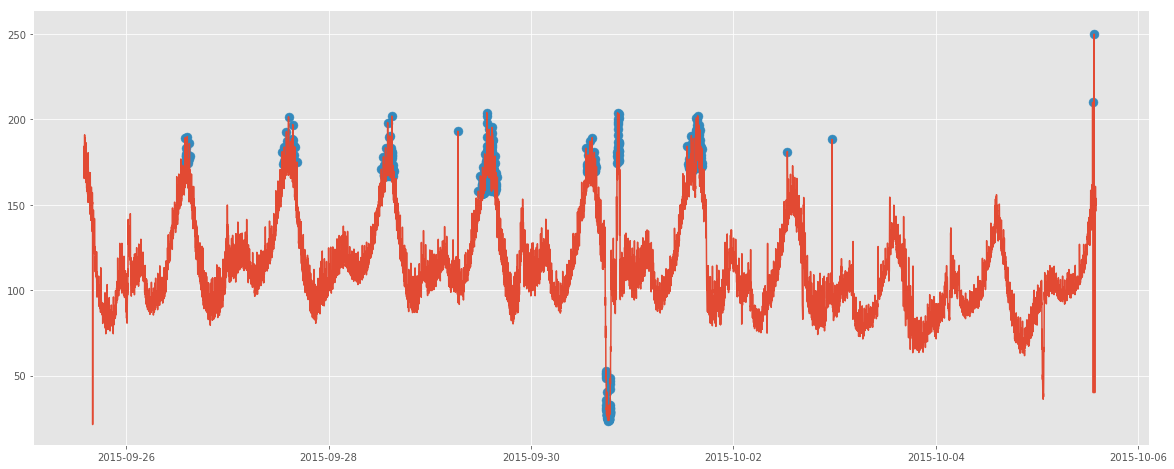

In [17]:
plt.figure(figsize = (20, 8))
plt.plot(m4['count'], color='C0')
plt.scatter(m4.index[m4['anomaly']==1], m4['count'][m4['anomaly']==1], color='C1', s=80)
plt.show()

### ARIMA

In [18]:
#Copy datasets for use in ARIMA models
a1 = df2.copy()
a2 = df3.copy()
a3 = df4.copy().resample('15T').mean()

In [19]:
#Set ARIMA parameters for each dataset
arima1 = sm.tsa.statespace.SARIMAX(a1['cars'], trend='n', order=(0,1,1), seasonal_order=(0,1,1,96))
r1 = arima1.fit()
a1['f1'] = r1.predict(start = 450, end= 738, dynamic= True)
print (r1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               cars   No. Observations:                  738
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 96)   Log Likelihood               -1451.629
Date:                            Fri, 20 Apr 2018   AIC                           2909.257
Time:                                    11:39:16   BIC                           2923.069
Sample:                                09-10-2015   HQIC                          2914.583
                                     - 09-17-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6265      0.012    -51.869      0.000      -0.650      -0.603
ma.S.L96      -0.6410      0.030   

In [20]:
arima2 = sm.tsa.statespace.SARIMAX(a2['mph'], trend='n', order=(0,1,1), seasonal_order=(0,1,1,96))
r2 = arima2.fit()
a2['f2'] = r2.predict(start = 450, end= 738, dynamic= True)
print (r2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                mph   No. Observations:                  738
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 96)   Log Likelihood               -1819.912
Date:                            Fri, 20 Apr 2018   AIC                           3645.825
Time:                                    11:39:56   BIC                           3659.637
Sample:                                09-10-2015   HQIC                          3651.151
                                     - 09-17-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3990      0.016    -25.006      0.000      -0.430      -0.368
ma.S.L96      -0.5539      0.022   

In [21]:
arima3 = sm.tsa.statespace.SARIMAX(a3['count'], trend='n', order=(0,1,1), seasonal_order=(0,1,1,96))
r3 = arima3.fit()
a3['f3'] = r3.predict(start = 700, end= 960, dynamic= True)
print (r3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                  960
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 96)   Log Likelihood               -2872.106
Date:                            Fri, 20 Apr 2018   AIC                           5750.213
Time:                                    11:42:07   BIC                           5764.814
Sample:                                09-25-2015   HQIC                          5755.773
                                     - 10-05-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1551      0.011     14.377      0.000       0.134       0.176
ma.S.L96      -0.9994     11.358   

In [22]:
#Apply roling window to the ARIMA predictions 
a1['rstd'] = a1['f1'][450:739].rolling(window=96).std()*3
a1['rmt'] = a1['f1'] + a1['rstd']
a1['rmb'] = a1['f1'] - a1['rstd']

a2['rstd'] = a2['f2'][450:739].rolling(window=96).std()*7
a2['rmt'] = a2['f2'] + a2['rstd']
a2['rmb'] = a2['f2'] - a2['rstd']

a3['rstd'] = a3['f3'][700:961].rolling(window=96).std()*1.5
a3['rmt'] = a3['f3'] + a3['rstd']
a3['rmb'] = a3['f3'] - a3['rstd']

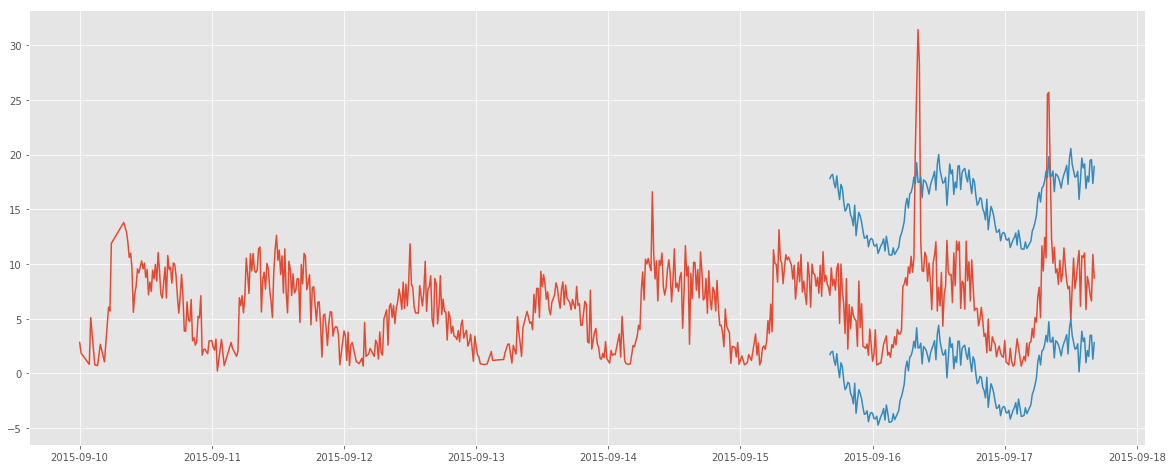

In [23]:
plt.figure(figsize = (20, 8))
plt.plot(a1['cars'], color='C0')
plt.plot(a1['rmt'], color='C1')
plt.plot(a1['rmb'], color='C1')
plt.show()

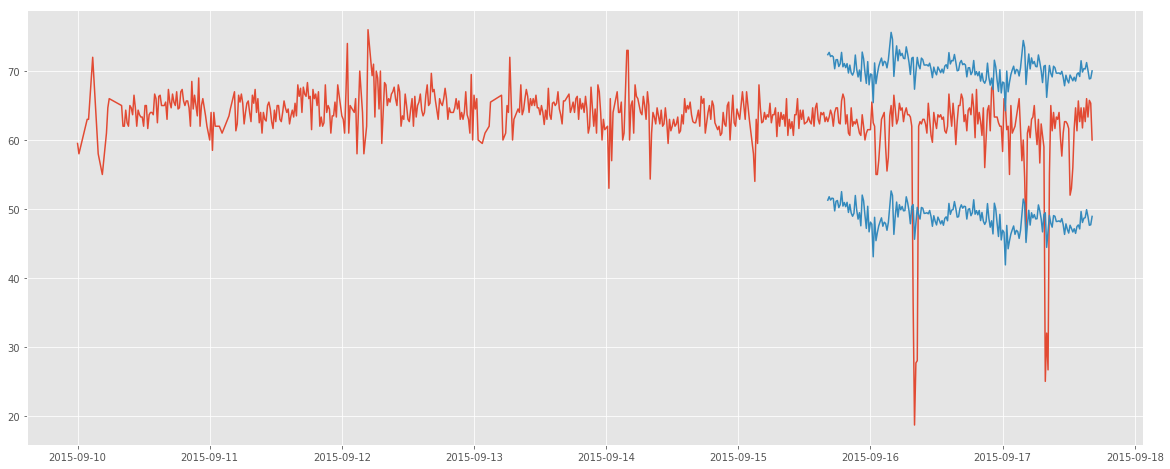

In [24]:
plt.figure(figsize = (20, 8))
plt.plot(a2['mph'], color='C0')
plt.plot(a2['rmt'], color='C1')
plt.plot(a2['rmb'], color='C1')
plt.show()

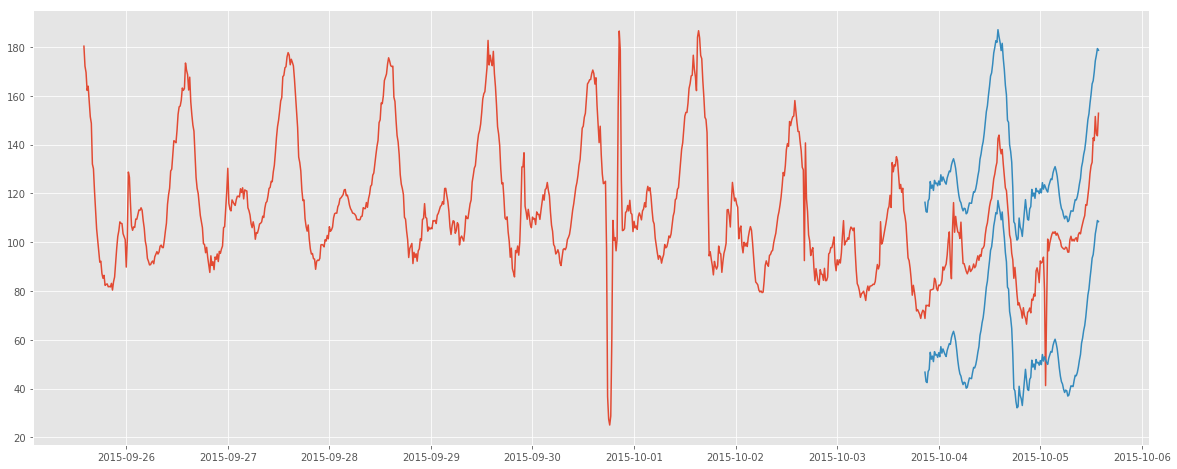

In [25]:
plt.figure(figsize = (20, 8))
plt.plot(a3['count'], color='C0')
plt.plot(a3['rmt'], color='C1')
plt.plot(a3['rmb'], color='C1')
plt.show()

In [26]:
#Identify anomalies if they do not fall within the standard deviations from model predictions 
a1['anomaly'] = [ 1 if (i> a1['rmt'][p]) or (i< a1['rmb'][p]) else 0 for p,i in enumerate(a1['cars'])]
a2['anomaly'] = [ 1 if (i> a2['rmt'][p]) or (i< a2['rmb'][p]) else 0 for p,i in enumerate(a2['mph'])]
a3['anomaly'] = [ 1 if (i> a3['rmt'][p]) or (i< a3['rmb'][p]) else 0 for p,i in enumerate(a3['count'])]

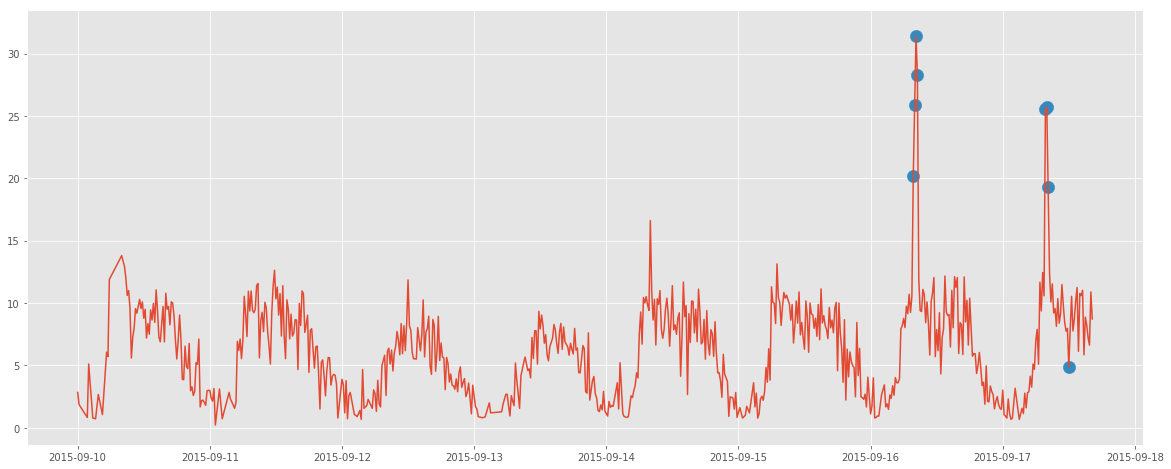

In [27]:
plt.figure(figsize = (20, 8))
plt.plot(a1['cars'], color='C0')
plt.scatter(a1.index[a1['anomaly']==1], a1['cars'][a1['anomaly']==1], color='C1', s=150)
plt.show()

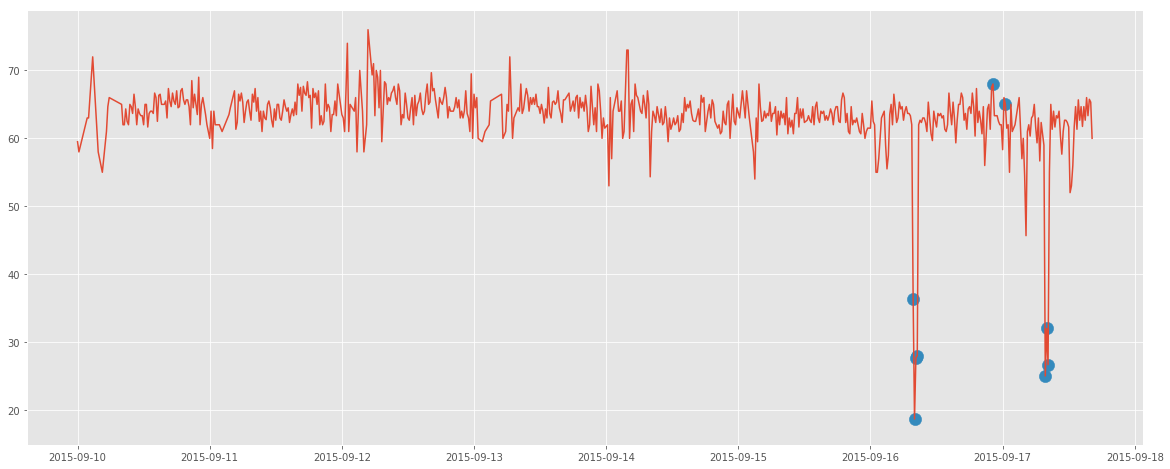

In [28]:
plt.figure(figsize = (20, 8))
plt.plot(a2['mph'], color='C0')
plt.scatter(a2.index[a2['anomaly']==1], a2['mph'][a2['anomaly']==1], color='C1', s=150)
plt.show()

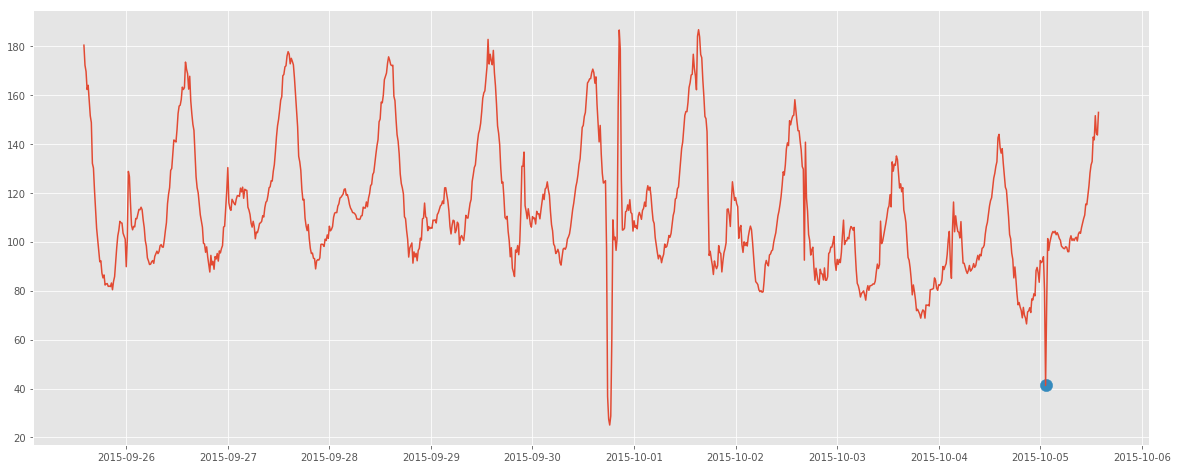

In [29]:
plt.figure(figsize = (20, 8))
plt.plot(a3['count'], color='C0')
plt.scatter(a3.index[a3['anomaly']==1], a3['count'][a3['anomaly']==1], color='C1', s=150)
plt.show()

### Seasonal Hybrid ESD

In [30]:
#Copy dataframes for use in Seasonal Hybrid ESD
s1 = df1.copy()
s2 = df2.copy()
s3 = df3.copy()
s4 = df4.copy()

In [31]:
#Decompose each dataset into trend, seasonal and residuals
d1 = sm.tsa.seasonal_decompose(s1, model = 'additive', two_sided = False, freq = 96)
d2 = sm.tsa.seasonal_decompose(s2, model = 'additive', two_sided = False, freq = 96)
d3 = sm.tsa.seasonal_decompose(s3, model = 'additive', two_sided = False, freq = 96)
d4 = sm.tsa.seasonal_decompose(s4, model = 'additive', two_sided = False, freq = 1440)

In [32]:
#Create columns with result from the decomposition
decomposition_1 = pd.concat([s1, d1.trend, d1.seasonal, d1.resid], axis = 1)
decomposition_1.columns = ['sampled', 'trend', 'seasonal', 'residual']

decomposition_2 = pd.concat([s2, d2.trend, d2.seasonal, d2.resid], axis = 1)
decomposition_2.columns = ['sampled', 'trend', 'seasonal', 'residual']

decomposition_3 = pd.concat([s3, d3.trend, d3.seasonal, d3.resid], axis = 1)
decomposition_3.columns = ['sampled', 'trend', 'seasonal', 'residual']

decomposition_4 = pd.concat([s4, d4.trend, d4.seasonal, d4.resid], axis = 1)
decomposition_4.columns = ['sampled', 'trend', 'seasonal', 'residual']

Text(0.5,0,'date')

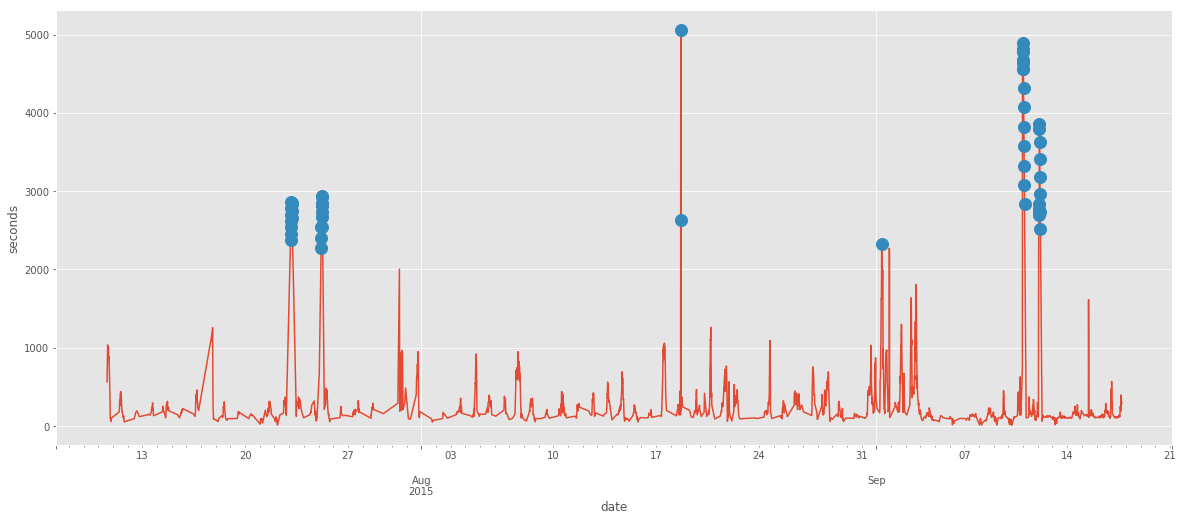

In [33]:
#Run ESD, identify anomalies and plot results
resid_1 = decomposition_1['residual'][96:]
nos, anomalies = pyasl.generalizedESD(resid_1, 50,0.01, fullOutput = False)
mark_1 = [i + 96 for i in anomalies]
decomposition_1['sampled'].plot( marker = 'o', markevery = mark_1 , markerfacecolor = 'C1', markeredgecolor = 'C1', markersize=12, figsize = (20, 8))
plt.ylabel('seconds')
plt.xlabel('date')

Text(0.5,0,'date')

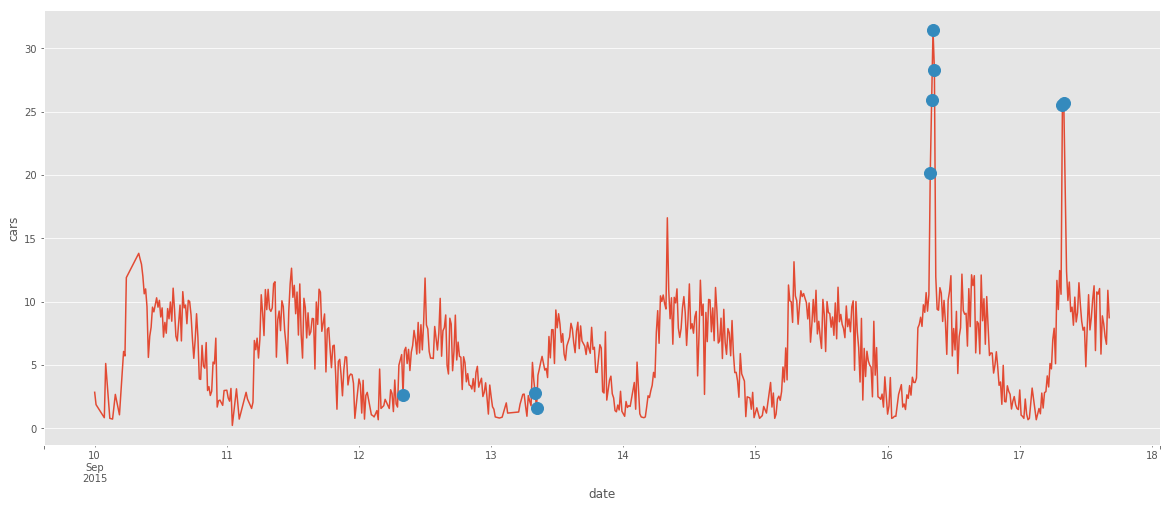

In [34]:
resid_2 = decomposition_2['residual'][96:]
nos, anomalies = pyasl.generalizedESD(resid_2, 10,0.05, fullOutput = False)
mark_2 = [i + 96 for i in anomalies]
decomposition_2['sampled'].plot( marker = 'o', markevery = mark_2 , markerfacecolor = 'C1', markeredgecolor = 'C1', markersize=12, figsize = (20, 8))
plt.ylabel('cars')
plt.xlabel('date')

Text(0.5,0,'date')

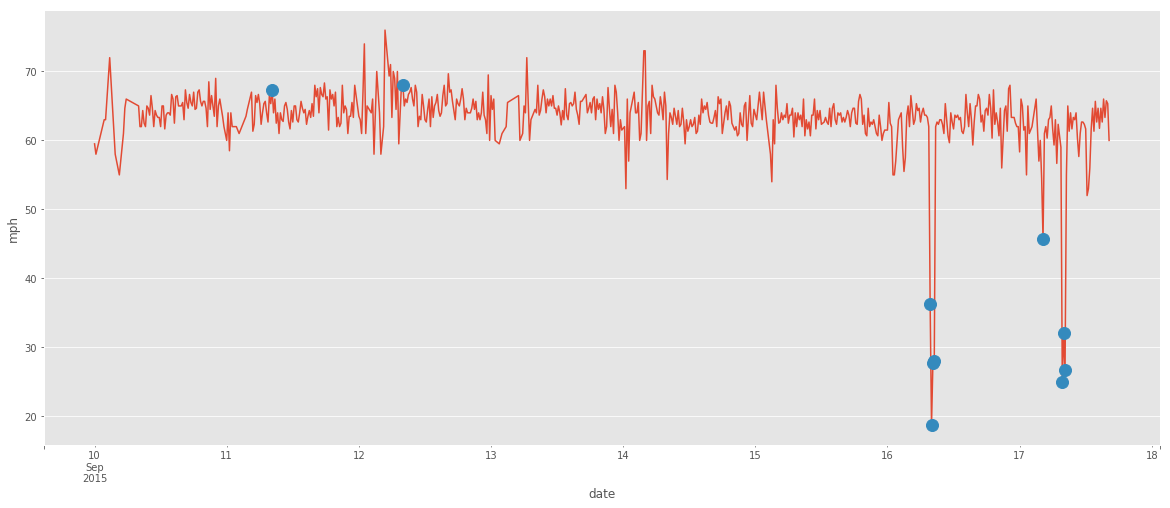

In [35]:
resid_3 = decomposition_3['residual'][96:]
nos, anomalies = pyasl.generalizedESD(resid_3, 10, 0.1, fullOutput = False)
mark_3 = [i + 96 for i in anomalies]
decomposition_3['sampled'].plot( marker = 'o', markevery = mark_3 , markerfacecolor = 'C1', markeredgecolor = 'C1', markersize=12, figsize = (20, 8))
plt.ylabel('mph')
plt.xlabel('date')

Text(0.5,0,'date')

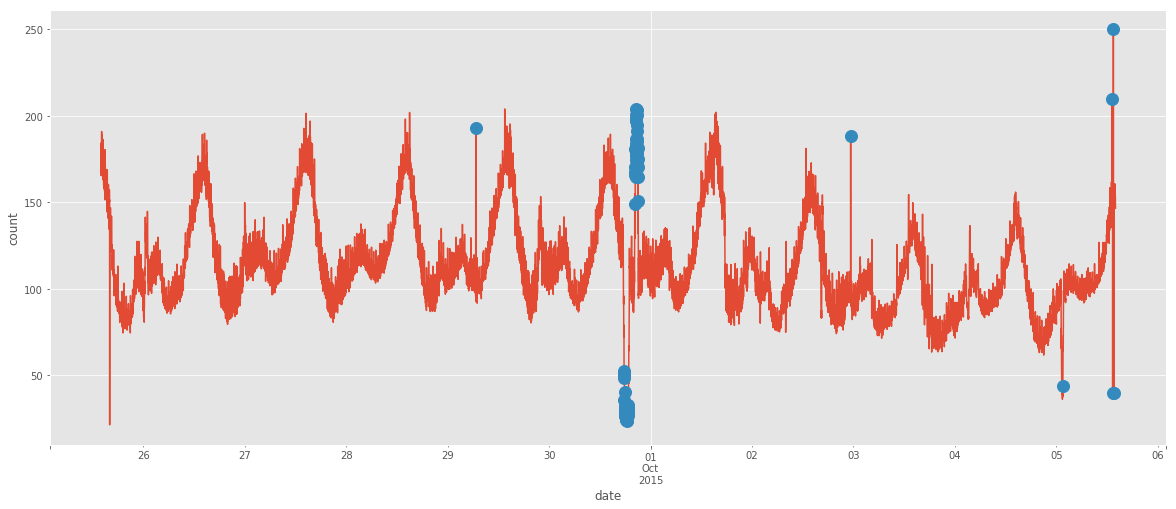

In [36]:
resid_4 = decomposition_4['residual'][1440:]
nos, anomalies = pyasl.generalizedESD(resid_4, 150, 0.01, fullOutput = False)
mark_4 = [i + 1440 for i in anomalies]
decomposition_4['sampled'].plot( marker = 'o', markevery = mark_4 , markerfacecolor = 'C1', markeredgecolor = 'C1', markersize=12, figsize = (20, 8))
plt.ylabel('count')
plt.xlabel('date')

### Isolation Forest

In [40]:
#Copy dataframe
i1 = df2.copy()
i1['mph'] = df3.copy()['mph']
i1 = i1.reset_index()

#Create features
i1['daytime'] = [ 0 if ((i >= 0) & (i <= 5)) 
             else 1  if ((i >= 6) & (i <= 11))
             else 2 if ((i >= 12) & (i <= 19))
             else 3 for i in i1.timestamp.dt.hour]
i1['weekday'] = i1.timestamp.dt.dayofweek
data_1 = i1[['cars','mph','daytime','weekday']]
scaler_1 = preprocessing.StandardScaler()
sdata_1 = scaler_1.fit_transform(data_1)

#Train model
model =  IsolationForest(contamination = 0.01, n_jobs = -1, bootstrap =True, random_state=1)
model.fit(pd.DataFrame(sdata_1))
i1['anomaly'] = pd.Series(model.predict(pd.DataFrame(sdata_1)))
i1['anomaly'] = i1['anomaly'].map( {1: 0, -1: 1} )
i1 = i1.set_index(i1['timestamp'], drop = True)
print(i1['anomaly'].value_counts())

0    730
1      8
Name: anomaly, dtype: int64


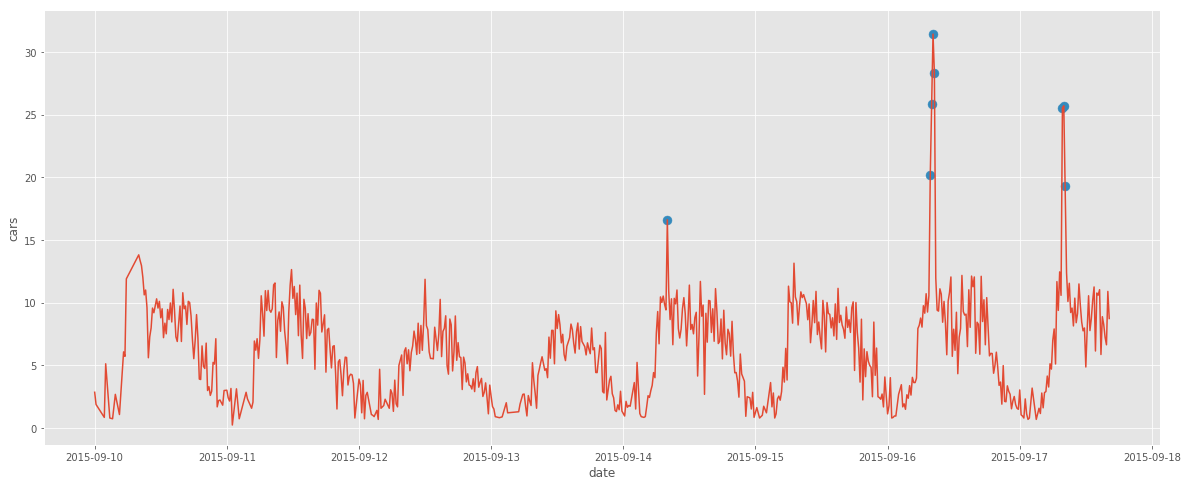

In [41]:
plt.figure(figsize = (20, 8))
plt.plot(i1['cars'], color='C0')
plt.scatter(i1.index[i1['anomaly']==1], i1['cars'][i1['anomaly']==1], color='C1', s=80)
plt.ylabel('cars')
plt.xlabel('date')
plt.show()

In [43]:
i2 = df4.copy()
i2 = i2.reset_index()
i2['daytime'] = [ 0 if ((i >= 0) & (i <= 5)) 
             else 1  if ((i >= 6) & (i <= 11))
             else 2 if ((i >= 12) & (i <= 19))
             else 3 for i in i2.timestamp.dt.hour]
i2['weekday'] = i2.timestamp.dt.dayofweek
data_2 = i2[['count','daytime','weekday']]
scaler_2 = preprocessing.StandardScaler()
sdata_2 = scaler_2.fit_transform(data_2) 

model_2 =  IsolationForest(contamination = 0.008, n_jobs = -1, bootstrap =True, random_state=2)
model_2.fit(pd.DataFrame(sdata_2))
i2['anomaly'] = pd.Series(model_2.predict(pd.DataFrame(sdata_2)))
i2['anomaly'] = i2['anomaly'].map( {1: 0, -1: 1} )
print(i2['anomaly'].value_counts())

0    14281
1      117
Name: anomaly, dtype: int64


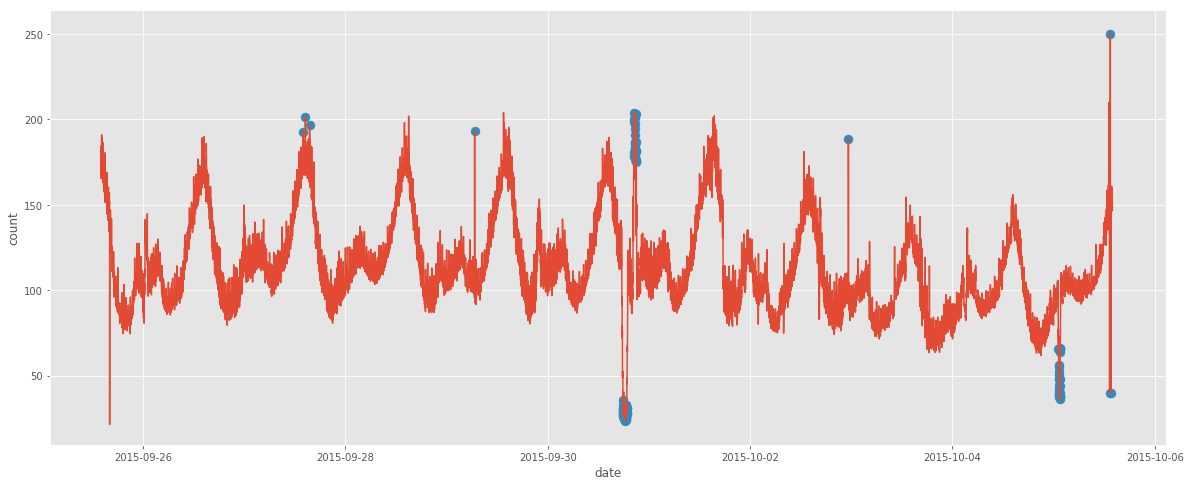

In [44]:
i2 = i2.set_index(i2['timestamp'], drop = True)
plt.figure(figsize = (20, 8))
plt.plot(i2['count'], color='C0')
plt.scatter(i2.index[i2['anomaly']==1], i2['count'][i2['anomaly']==1], color='C1', s=80)
plt.ylabel('count')
plt.xlabel('date')
plt.show()